In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [6]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
import util
import scvelo as scv
import rf
import torch

PLT_CELL = 3.5

In [7]:
import glob
DATA_PATH = "../data/simulation/Synthetic/"
s = "TF"
i = 1
paths = glob.glob(os.path.join(DATA_PATH, f"dyn-{s}/dyn-{s}*-{i}")) + glob.glob(os.path.join(DATA_PATH, f"dyn-{s}_ko*/dyn-{s}*-{i}"))
names = [os.path.basename(p).split("-")[1] for p in paths]

adatas = [util.load_adata(p) for p in paths]

T = 5
t_bins = np.linspace(0, 1, T+1)[:-1]
def bin_timepoints(adata):
    adata.obs["t"] = np.digitize(adata.obs.t_sim, t_bins)-1
for adata in adatas:
    bin_timepoints(adata)

In [8]:
kos = []
for p in paths:
    try:
        kos.append(os.path.basename(p).split('_ko_')[1].split("-")[0])
    except:
        kos.append(None)
kos

[None, 'g6', 'g5', 'g2', 'g7', 'g3', 'g4', 'g8']

In [9]:
# for (adata, name) in zip(adatas, names):
#     sc.pl.scatter(adata, basis = "pca", color = "t", title = name,)

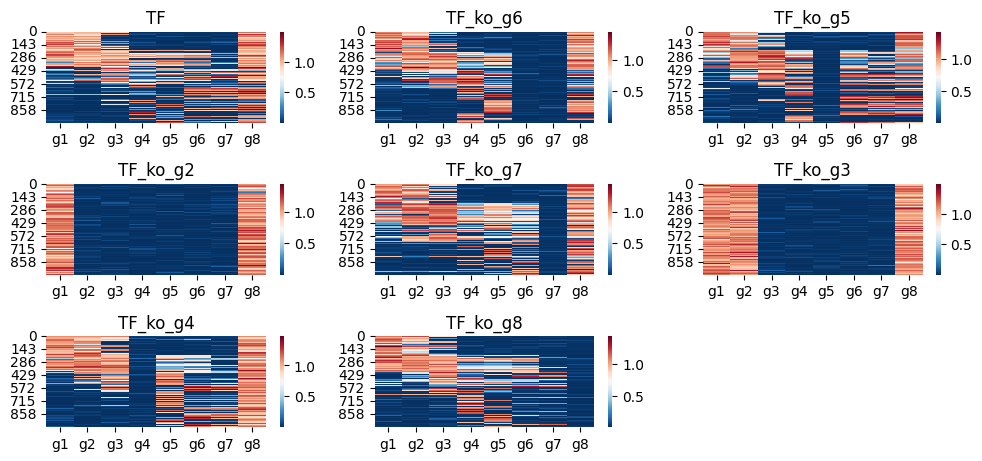

In [10]:
import seaborn as sb
plt.figure(figsize = (10, 6))
for i, (adata, name) in enumerate(zip(adatas, names)):
    plt.subplot(4, 3, i+1)
    sb.heatmap(pd.DataFrame(adata.X[np.argsort(adata.obs.t), :], columns = adata.var.index), cmap = "RdBu_r")
    plt.title(name)
    plt.axis("auto")
plt.tight_layout()

In [11]:
A_refs = []
for p, name in zip(paths, names):
    df = pd.read_csv(os.path.join(os.path.dirname(p), "refNetwork.csv"))
    n_genes = adata.shape[1]
    A_ref = pd.DataFrame(np.zeros((n_genes, n_genes), int), index = adata.var.index, columns=adata.var.index)
    for i in range(df.shape[0]):
        _i = df.iloc[i, 1]
        _j = df.iloc[i, 0]
        _v = {"+" : 1, "-" : -1}[df.iloc[i, 2]]
        A_ref.loc[_i, _j] = _v
    # plt.figure(figsize = (3, 3));
    # sb.heatmap(A_ref, vmin = -1, vmax = 1, cmap = "RdBu_r"); plt.gca().invert_yaxis()
    # plt.title(name)
    A_refs.append(A_ref)

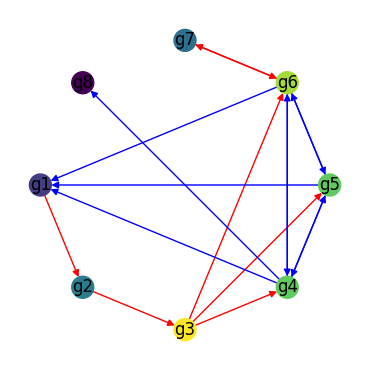

In [12]:
import networkx as nx
_A = A_refs[np.where(np.array(kos) == None)[0][0]]
np.fill_diagonal(_A.values, 0)
g = nx.DiGraph(_A)
centralities = nx.centrality.eigenvector_centrality(g.reverse())
nx.set_node_attributes(g, centralities, name = "centrality")
plt.figure(figsize = (PLT_CELL, PLT_CELL))
edge_colors = ['red' if g[u][v]['weight'] > 0 else 'blue' for u, v in g.edges()]
nx.draw(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 2.5e2, pos=nx.shell_layout(g))
plt.tight_layout()
plt.savefig("../figures/TF_net_true.pdf")

In [13]:
kos

[None, 'g6', 'g5', 'g2', 'g7', 'g3', 'g4', 'g8']

In [14]:
centralities = pd.Series(centralities)
ko_genes = centralities.index[np.argsort(np.array(centralities))[::-1]][:4]

ko_idx = [np.where(np.array(kos) == None)[0][0], ]
for x in ko_genes:
    try:
        ko_idx.append(np.where(np.array(kos) == x)[0][0])
    except:
        pass
ko_idx

[0, 5, 1, 6, 2]

In [15]:
[kos[i] for i in ko_idx]

[None, 'g3', 'g6', 'g4', 'g5']

In [17]:
options = {
    "lr" : 0.1, 
    "reg_sinkhorn" : 0.1,
    "reg_A" : 1e-3, 
    "reg_A_elastic" : 0, 
    "iter" : 1000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam
}

estim_alt = rf.Estimator([adatas[i] for i in ko_idx], [kos[i] for i in ko_idx], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"])
estim_alt.fit(print_iter=100, alg = "alternating", update_couplings_iter=250);

estim_alt_wt = rf.Estimator([adatas[i] for i in ko_idx[:1]], [kos[i] for i in ko_idx[:1]], 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"])
estim_alt_wt.fit(print_iter=100, alg = "alternating", update_couplings_iter=250);

Updating transport plans
iteration 0, loss = -0.9029535682139294, L = -0.9029535682139294, R = 0.0
iteration 100, loss = -1.463535504198581, L = -1.5214061456096388, R = 57.87064141105792
iteration 200, loss = -1.4704036438169057, L = -1.5280994457279697, R = 57.69580191106405
iteration 300, loss = -1.5406402088791447, L = -1.6053046170327694, R = 64.6644081536247
iteration 400, loss = -1.5423720821958324, L = -1.6083566905705198, R = 65.98460837468731
iteration 500, loss = -1.5447082960202392, L = -1.611093754594139, R = 66.38545857389985
iteration 600, loss = -1.545517265933868, L = -1.6133348105586915, R = 67.81754462482351
iteration 700, loss = -1.5455534686581314, L = -1.6134638982957157, R = 67.9104296375842
iteration 800, loss = -1.5458968805636355, L = -1.6140852820617937, R = 68.1884014981582
iteration 900, loss = -1.5458783840408703, L = -1.6142062153191408, R = 68.3278312782704
Updating transport plans
iteration 0, loss = -1.320157173691212, L = -1.320157173691212, R = 0.0
i

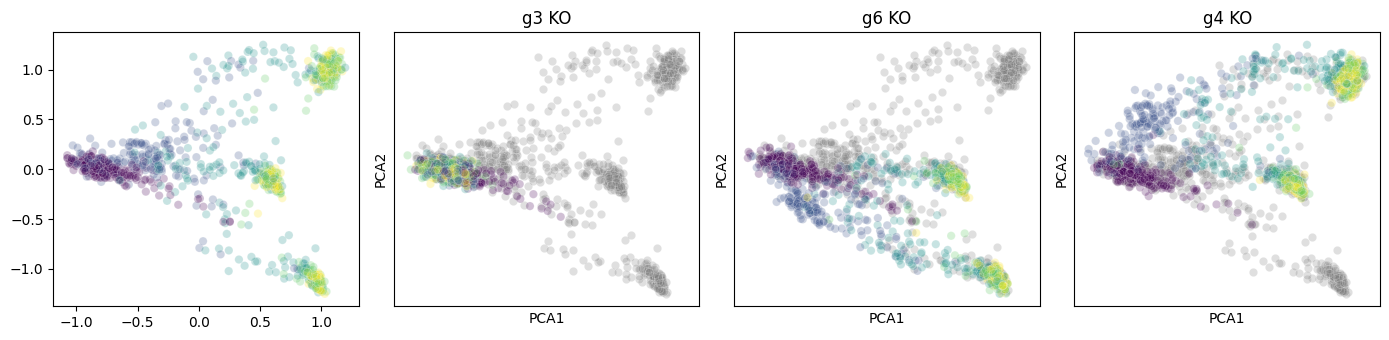

In [28]:
plt.figure(figsize = (4*PLT_CELL, PLT_CELL))
idx = adata_all.obs.condition == "TF"
plt.subplot(1, 4, 1)
sb.scatterplot(x = adata_all.obsm["X_pca"][idx, 0], y = adata_all.obsm["X_pca"][idx, 1], c = adata_all.obs.t[idx], alpha = 0.25)
for i in range(3):
    plt.subplot(1, 4, i+2)
    idx = adata_all.obs.condition == "TF"
    sb.scatterplot(x = adata_all.obsm["X_pca"][idx, 0], y = adata_all.obsm["X_pca"][idx, 1], c = 'grey', alpha = 0.25)
    idx_ = adata_all.obs.condition == kos[ko_idx[i+1]]
    sb.scatterplot(x = adata_all.obsm["X_pca"][idx_, 0], y = adata_all.obsm["X_pca"][idx_, 1], alpha = 0.25, c = adata_all.obs.t[idx_])
    plt.title(f"{kos[ko_idx[i+1]]} KO")
    plt.xlabel("PCA1"); plt.ylabel("PCA2")
    plt.xticks([], []); plt.yticks([], [])
plt.tight_layout()

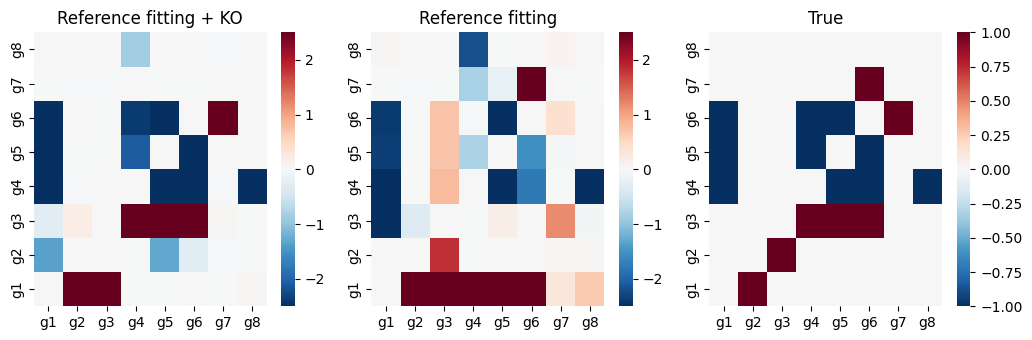

In [29]:
A_ref = A_refs[np.where(np.array(kos) == None)[0][0]].to_numpy(); np.fill_diagonal(A_ref, 0)
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 3, 1)
sb.heatmap(pd.DataFrame(estim_alt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting + KO")
plt.subplot(1, 3, 2)
sb.heatmap(pd.DataFrame(estim_alt_wt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting")
plt.subplot(1, 3, 3)
sb.heatmap(pd.DataFrame(A_ref, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1.0, vmax = 1.0, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("True")
plt.tight_layout()

In [30]:
A_ref = A_refs[np.where(np.array(kos) == None)[0][0]].to_numpy(); np.fill_diagonal(A_ref, 0)

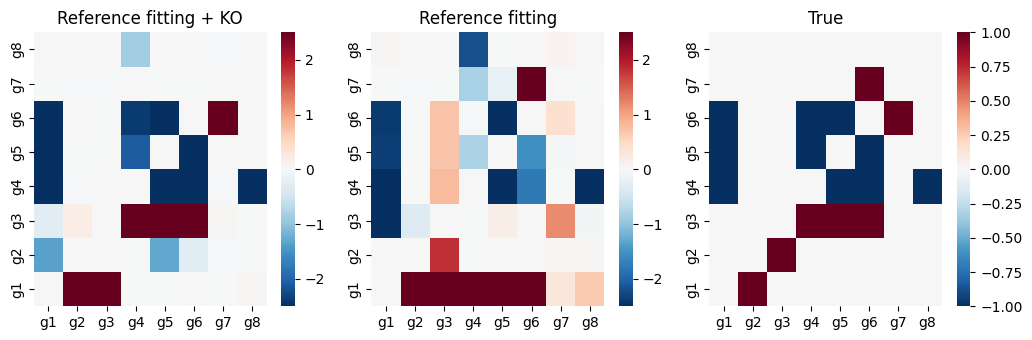

In [31]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 3, 1)
sb.heatmap(pd.DataFrame(estim_alt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting + KO")
plt.subplot(1, 3, 2)
sb.heatmap(pd.DataFrame(estim_alt_wt.A, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -2.5, vmax = 2.5, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("Reference fitting")
plt.subplot(1, 3, 3)
sb.heatmap(pd.DataFrame(A_ref, index = adatas[0].var.index, columns = adatas[0].var.index), vmin = -1.0, vmax = 1.0, cmap = "RdBu_r")
plt.gca().invert_yaxis()
plt.title("True")
plt.tight_layout()

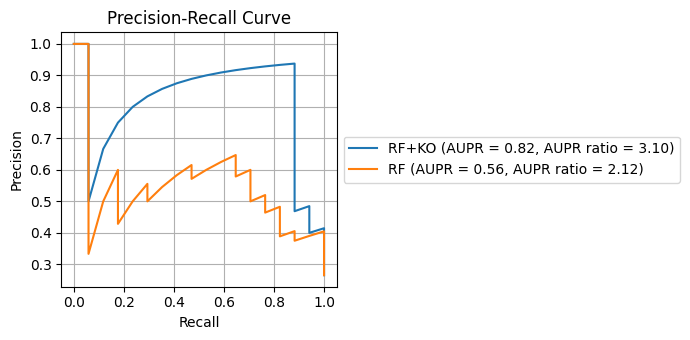

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = np.abs(np.sign(A_ref).astype(int).flatten())
ys["RF+KO"] = np.abs(estim_alt.A.flatten())
ys["RF"] = np.abs(estim_alt_wt.A.flatten())

plt.figure(figsize=(2*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AUPR = {avg_prec:.2f}, AUPR ratio = {avg_prec / y_true.mean():.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()